# Markov Chain Monte Carlo

In [1]:
using Pkg

In [2]:
# This is a numerical integration package that we use for cosmology distances
Pkg.add("QuadGK")

  Updating registry at `C:\Users\andre\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %.2 % [=>                                       ]  2.1 %]  5.2 %.5 %                                    ]  9.0 %                                    ]  9.9 %Fetching: [=====>                                   ]  11.6 %>                                  ]  12.7 %5 %                                 ]  17.5 % [========>                                ]  18.4 %                                ]  19.1 %Fetching: [=========>                               ]  20.5 %.5 %>                              ]  23.1 %8 %==========>                              ]  24.8 %]  27.1 %                            ]  28.8 %4 %                          ]  33.3 %34.9 % %.3 %>                    ]  49.8 %]  50.7 %56.6 %5 %>               ]  61.1 %3 % %===========================>             ]  65.3 % % % [=============

In [3]:
using QuadGK
using Plots
using Statistics

In [4]:
function read_data()
    open("p99-data.txt", "r") do io
        line = readline(io)
        # drop "#"
        if line[1] == '#'
            line = line[2:end]
        end
        words = split(line)
        # println(words)
        ncols = length(words)
        lines = readlines(io)
        nlines = length(lines)
        #println("Read ", nlines, " lines")
        names = []
        redshift = zeros(nlines)
        m_b_eff = zeros(nlines)
        sigma_m_b_eff = zeros(nlines)
        for i in 1:nlines
            #println("Line: ", lines[i])
            # HACK --- I'm hard-coding which columns contain which data
            words = split(lines[i])
            push!(names, words[1])
            redshift[i] = parse(Float64, words[2])
            m_b_eff[i] = parse(Float64, words[9])
            sigma_m_b_eff[i] = parse(Float64, words[10])
        end
        return names, redshift, m_b_eff, sigma_m_b_eff
    end
end;

In [5]:
(name, z, m_B, merr) = read_data();

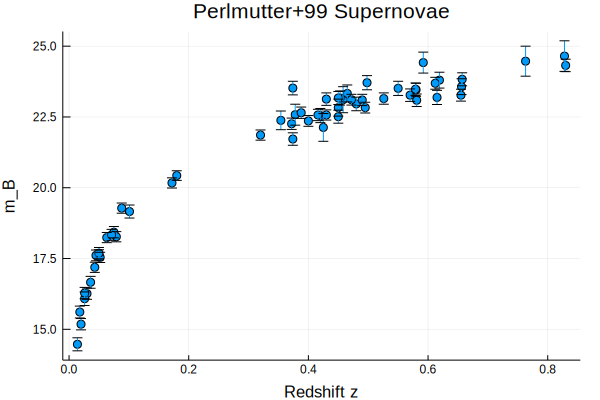

In [6]:
plot(z, m_B, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")

In [7]:
# These functions are taken from astropy.cosmology, specialized for
# the FlatLambdaCDM model.
#

# A minimal Flat Lambda CDM model
mutable struct LCDM
    Om0::Float64
    Ode0::Float64
    hubble_distance::Float64
end

#
function luminosity_distance(cosmology, z)
    return (1. + z) * comoving_transverse_distance(cosmology, z)
end
function comoving_transverse_distance(cosmology, z)
    return comoving_transverse_distance_z1z2(cosmology, 0., z)
end
function comoving_transverse_distance_z1z2(cosmology, z1, z2)
    # HERE we're assuming Ok0=0
    # (Omega curvature; the effective curvature density/critical density at z=0)
    return comoving_distance_z1z2(cosmology, z1, z2)
end

function comoving_distance_z1z2(cosmology, z1, z2)
    #hypergeometric_comoving_distance_z1z2(cosmology, z1, z2)
    integral_comoving_distance_z1z2(cosmology, z1, z2)
end

function integral_comoving_distance_z1z2(cosmology, z1, z2)
    function flcdm_inv_efunc_norel(z)
        Om0 = cosmology.Om0
        Ode0 = cosmology.Ode0
        return ((1. + z)^3 * Om0 + Ode0) ^ -0.5
    end
    # HERE we turn off relativistic species (Tcmb=0)
    (integral,error) = quadgk(flcdm_inv_efunc_norel, z1, z2)
    return cosmology.hubble_distance * integral
end

function hypergeometric_comoving_distance_z1z2(cosmology, z1, z2)
    # def _hypergeometric_comoving_distance_z1z2(self, z1, z2):
    s = ((1 - cosmology.Om0) / cosmology.Om0) ^ (1. / 3)
    # Use np.sqrt here to handle negative s (Om0>1).
    prefactor = cosmology.hubble_distance / sqrt(s * cosmology.Om0)
    return prefactor * (T_hypergeometric(s / (1 + z1)) -
                        T_hypergeometric(s / (1 + z2)))
end
function T_hypergeometric(x)
    #from scipy.special import hyp2f1
    return 2 * sqrt(x) * Nemo.hyp2f1(1. / 6, 1. / 2, 7. / 6, -x^3)
end;

In [8]:
function distance_modulus(universe, z)
    5. * log10.(luminosity_distance(universe, z) / 10.)
end;

In [9]:
function m_B_pred(z, M, Om)
    # Assume flat universe
    universe = LCDM(Om, 1.0 - Om, H)
    M .+ map(z->distance_modulus(universe, z), z)
end;

In [10]:
function fgbg_log_likelihood(z, m_B, merr, M, Om, pbad, Y, V)
    # If the "pbad" parameter goes outside the range 0 to 1, the prior is zero, so bail out.
    if (pbad < 0) || (pbad > 1)
        return -Inf
    end
    # If the "V" parameter goes negative, the prior is zero; bail out.
    if (V < 0)
        return -Inf
    end
    # Note -- don't work in log space here, and do include the 1/(sqrt(2*pi)*sigma) term.
    mBpreb = m_B_pred(z, M, Om)
    p_fg = @. 1. / (sqrt(2. *pi) * merr) * exp(-0.5 * (m_B - mBpreb)^2/(merr^2))
    bg_var = @. merr^2 + V
    p_bg = @. 1. / sqrt(2. *pi*bg_var) * exp(-0.5 * (m_B - Y)^2/bg_var)
    # Here, we weight the foreground probability by 1-pbad and the background by pbad,
    # and then take the log.
    lnl = sum(log.((1. .- pbad).*p_fg .+ pbad.*p_bg))
    return lnl
end;

In [11]:
function fgbg_logprob(params)
    # "unpack" the parameteres
    M, Om, pbad, Y, V = params
    fgbg_log_likelihood(z, m_B, merr, M, Om, pbad, Y, V)
end;

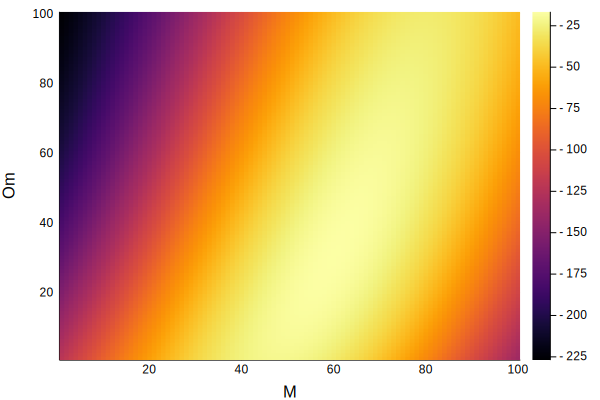

In [56]:
pbad = 0.1
H = 60.
Y = mean(m_B)
V = var(m_B)

M_lo,M_hi = 19.5, 20.5
Om_lo,Om_hi = 0.1, 0.9
MM = range(M_lo, stop=M_hi, length=100)
OmOm = range(Om_lo, stop=Om_hi, length=100)
LL = zeros((length(OmOm), length(MM)))
for i in 1:length(OmOm)
    for j in 1:length(MM)
        LL[i, j] = fgbg_logprob((MM[j], OmOm[i], pbad, Y, V))
    end
end
heatmap(LL, xlabel="M", ylabel="Om")

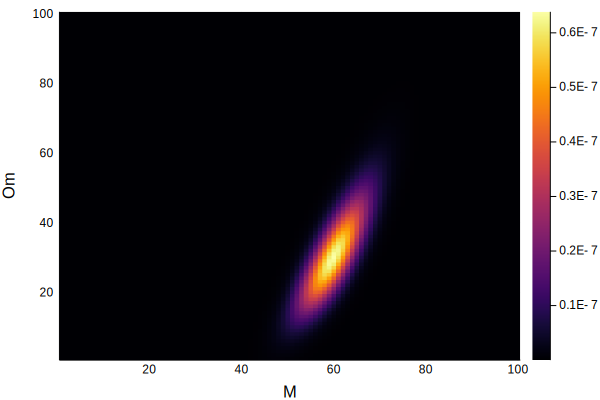

In [57]:
heatmap(exp.(LL), xlabel="M", ylabel="Om")

In [58]:
function run_mcmc(logprob_function, initial, jumpsizes, nsteps)
    nparams = length(initial)
    chain = zeros((nsteps, nparams))
    logprobs = zeros(nsteps)
    params = initial
    logprob = logprob_function(params)
    accepts = 0
    for i in 1:nsteps
        params_new = params .+ randn(nparams) .* jumpsizes
        logprob_new = logprob_function(params_new)
        if (exp(logprob_new - logprob) >= rand(Float64))
            logprob = logprob_new
            params = params_new
            accepts += 1
        end
        chain[i,:] .= params
        logprobs[i] = logprob
    end
    return chain, logprobs, accepts / nsteps
end;

In [59]:
initial = [19.5, 0.4, 0.1, mean(m_B), var(m_B)]
jumpsizes = [0.015, 0.03, 0.01, 0.5, 5]
chain,logprobs,acceptance = run_mcmc(fgbg_logprob, initial, jumpsizes, 1_0000);
acceptance

0.6641

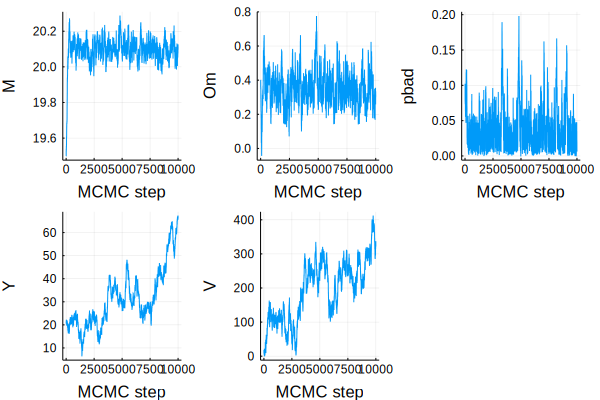

In [60]:
names = ["M", "Om", "pbad", "Y", "V"]
plots = []
for (i,n) in enumerate(names)
    p = plot(chain[:,i], xlabel="MCMC step", ylabel=n, label="") #"Param value", label=n)
    push!(plots, p)
end
plot(plots...)

In [61]:
plot(chain[:,1], chain[:,2], color=:black, legend =:topleft, label="", xlabel="M", ylabel="Om")
scatter!(chain[:,1], chain[:,2], zcolor=1:size(chain)[1], ms=3, label="MCMC positions", colorbar=false)

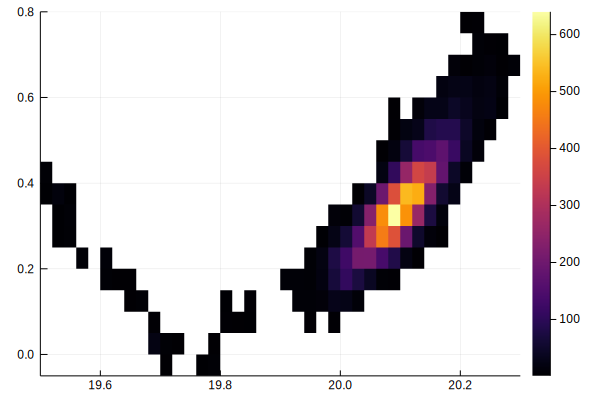

In [62]:
histogram2d(chain[:,1], chain[:,2])

In [71]:
chain,logprobs,acceptance = run_mcmc(fgbg_logprob, initial, jumpsizes, 1_000_000);
acceptance

0.648866

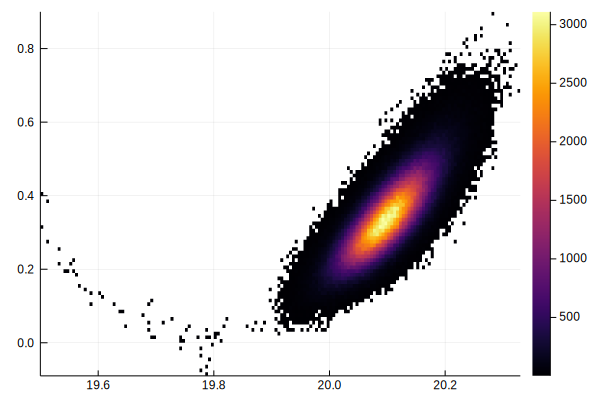

In [72]:
histogram2d(chain[:,1], chain[:,2])

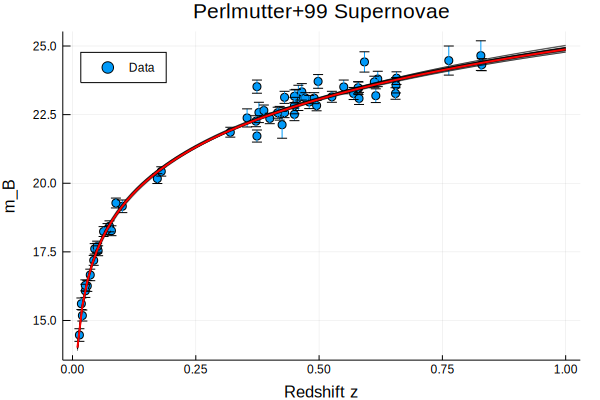

In [82]:
samples = chain[rand(1000:(size(chain)[1]), 20), :]
plot(z, m_B, yerr=merr, seriestype=:scatter, legend=:topleft, label="Data",xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")
zgrid = 0.01:0.01:1.
for i in 1:size(samples)[1]
    M = samples[i, 1]
    Om = samples[i, 2]
    universe_i = LCDM(Om, 1.0-Om, H)
    DL_i = map(z->distance_modulus(universe_i, z), zgrid)
    plot!(zgrid, M .+ DL_i, alpha=0.5, color=:black, label="")
end
meanM,meanOm = mean(chain[1000:end, 1]), mean(chain[1000:end, 2])
universe = LCDM(meanOm, 1.0-meanOm, H)
DLx = map(z->distance_modulus(universe, z), z)
offset = median(m_B - DLx)
DL = map(z->distance_modulus(universe, z), zgrid)
plot!(zgrid, offset .+ DL, color=:red, label="", linewidth=2)

# Gibbs Sampling MCMC

In [64]:
function run_gibbs_mcmc(logprob_function, initial, jumpsizes, nsteps)
    nparams = length(initial)
    chain = zeros((nsteps, nparams))
    logprobs = zeros(nsteps)
    params = initial
    logprob = logprob_function(params)
    accepts = zeros(nparams)
    tries = zeros(nparams)
    for i in 1:nsteps
        # Choose which parameter to adjust this time
        j = rand(1:nparams)
        # Jump just that parameter.
        params_new = copy(params)
        params_new[j] += randn() * jumpsizes[j]
        logprob_new = logprob_function(params_new)
        if (exp(logprob_new - logprob) >= rand(Float64))
            logprob = logprob_new
            params = params_new
            accepts[j] += 1
        end
        tries[j] += 1
        chain[i,:] .= params
        logprobs[i] = logprob
    end
    return chain, logprobs, accepts ./ tries
end;

In [65]:
initial = [19.5, 0.4, 0.1, mean(m_B), var(m_B)]
jumpsizes = [0.015, 0.03, 0.01, 0.5, 5]
chain,logprobs,acceptance = run_gibbs_mcmc(fgbg_logprob, initial, jumpsizes, 1_0000);
acceptance

5-element Array{Float64,1}:
 0.8269324258629072
 0.8123406425293218
 0.8605792832596957
 0.9271623672230652
 0.8175813008130082

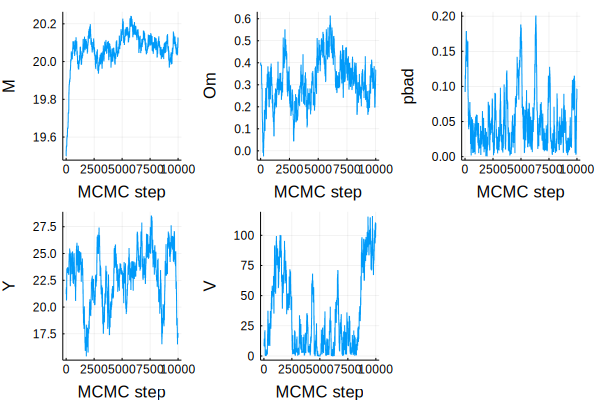

In [66]:
names = ["M", "Om", "pbad", "Y", "V"]
plots = []
for (i,n) in enumerate(names)
    p = plot(chain[:,i], xlabel="MCMC step", ylabel=n, label="")
    push!(plots, p)
end
plot(plots...)

In [67]:
plot(chain[:,1], chain[:,2], color=:black, legend =:topleft,label="", xlabel="M", ylabel="Om")
scatter!(chain[:,1], chain[:,2], zcolor=1:size(chain)[1], ms=3, label="MCMC positions", colorbar=false)

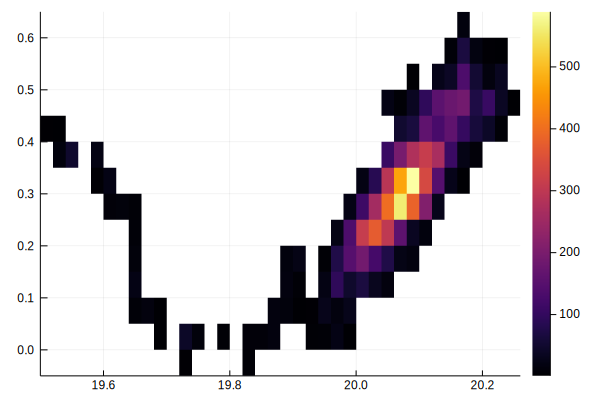

In [68]:
histogram2d(chain[:,1], chain[:,2])

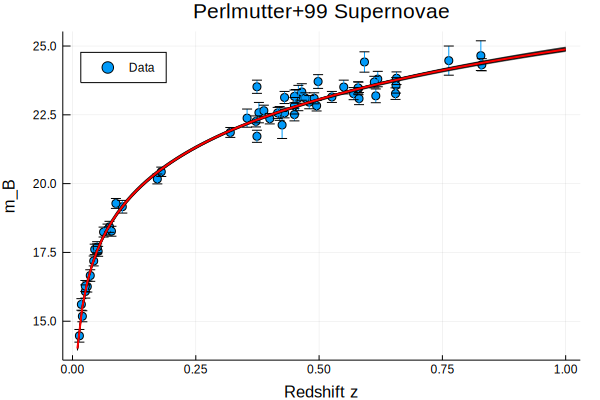

In [81]:
samples = chain[rand(1000:(size(chain)[1]), 20), :]
plot(z, m_B, yerr=merr, seriestype=:scatter, legend=:topleft, label="Data",xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")
zgrid = 0.01:0.01:1.
for i in 1:size(samples)[1]
    M = samples[i, 1]
    Om = samples[i, 2]
    universe_i = LCDM(Om, 1.0-Om, H)
    DL_i = map(z->distance_modulus(universe_i, z), zgrid)
    plot!(zgrid, M .+ DL_i, alpha=0.5, color=:black, label="")
end
meanM,meanOm = mean(chain[1000:end, 1]), mean(chain[1000:end, 2])
universe = LCDM(meanOm, 1.0-meanOm, H)
DLx = map(z->distance_modulus(universe, z), z)
offset = median(m_B - DLx)
DL = map(z->distance_modulus(universe, z), zgrid)
plot!(zgrid, offset .+ DL, color=:red, label="", linewidth=2)